# Notebook to make Fig. 8: SNR vs time

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
from scipy.stats import gaussian_kde
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../scripts')
from helper_functions import *
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load in data

Load in time-domain data from the detectors

In [1]:
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions from before/after each cutoff time

In [3]:
reconstruction_dict_all = np.load(data_dir+"waveform_reconstructions_all_detectors.npy", allow_pickle=True).item()
reconstruction_dict = {k:reconstruction_dict_all[k]['L1'] for k in reconstruction_dict_all.keys()}

Define strain in L1 

In [8]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

tstart = 1242442966.9077148
tend = 1242442967.607715
ra = 6.07546535866838
dec = -0.8000357325337637

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Max p strain from full run
lnP = reconstruction_dict['full']['params']['ln_posterior']
i_maxP = np.argmax(lnP)
L1_maxP_strain_wh = np.asarray(reconstruction_dict['full']['wh'][i_maxP])

# L1 strain
L1_LVC_strain_wh = wh_data_dict['L1']

# Transform timeseries into into units of M
reconstruction_times_M = (reconstruction_dict['time samples'] - t0_0M_dict['L1'])/dt_1M

Load in the SNRs corresponding to the reconstructions

In [30]:
snr_dict = np.load(data_dir+"snrs.npy", allow_pickle=True).item()

Format SNRs to plot

In [76]:
runs_before = []
network_snrs_before = []
runs_after = []
network_snrs_after = []

# For plotting aesthetics, don't plot too many points
runs_to_exclude = ['insp m37.5M', 'rd m37.5M', 'insp m32.5M', 'rd m32.5M', 'insp m27.5M', 
                   'rd m27.5M', 'insp m22.5M', 'rd m22.5M', 'insp m17.5M', 'rd m17.5M', 
                   'insp m12.5M', 'rd m12.5M', 'insp m7.5M', 'rd m7.5M', 'insp m2.5M', 
                   'rd m2.5M', 'insp 2.5M', 'rd 2.5M']

for run, snrs in snr_dict['L1'].items(): 
    
    if run not in runs_to_exclude: 
    
        # Calculate SNR
        network_snrs = np.asarray([calc_network_mf_SNR([L, H, V]) for L, H, V in zip(snr_dict['L1'][run], 
                                                                                     snr_dict['H1'][run], 
                                                                                     snr_dict['V1'][run])])
        quants_network_snr = np.quantile(network_snrs[~np.isnan(network_snrs)], (0.05, 0.5, 0.95))

        # pre-tcutoff analyses
        if run[0] == 'i': 

            run_float = float(run.split('insp')[-1].replace('m', '-')[:-1])

            runs_before.append(run_float)
            network_snrs_before.append(quants_network_snr)

        # post-tcutoff analyses
        elif run[0] == 'r': 

            run_float = float(run.split('rd')[-1].replace('m', '-')[:-1])

            runs_after.append(run_float)
            network_snrs_after.append(quants_network_snr)

        # full analysis for comparison
        elif run=='full':

            quants_network_snr_full = quants_network_snr
        
network_snrs_before = np.asarray(network_snrs_before)
network_snrs_after = np.asarray(network_snrs_after)

### Make figure

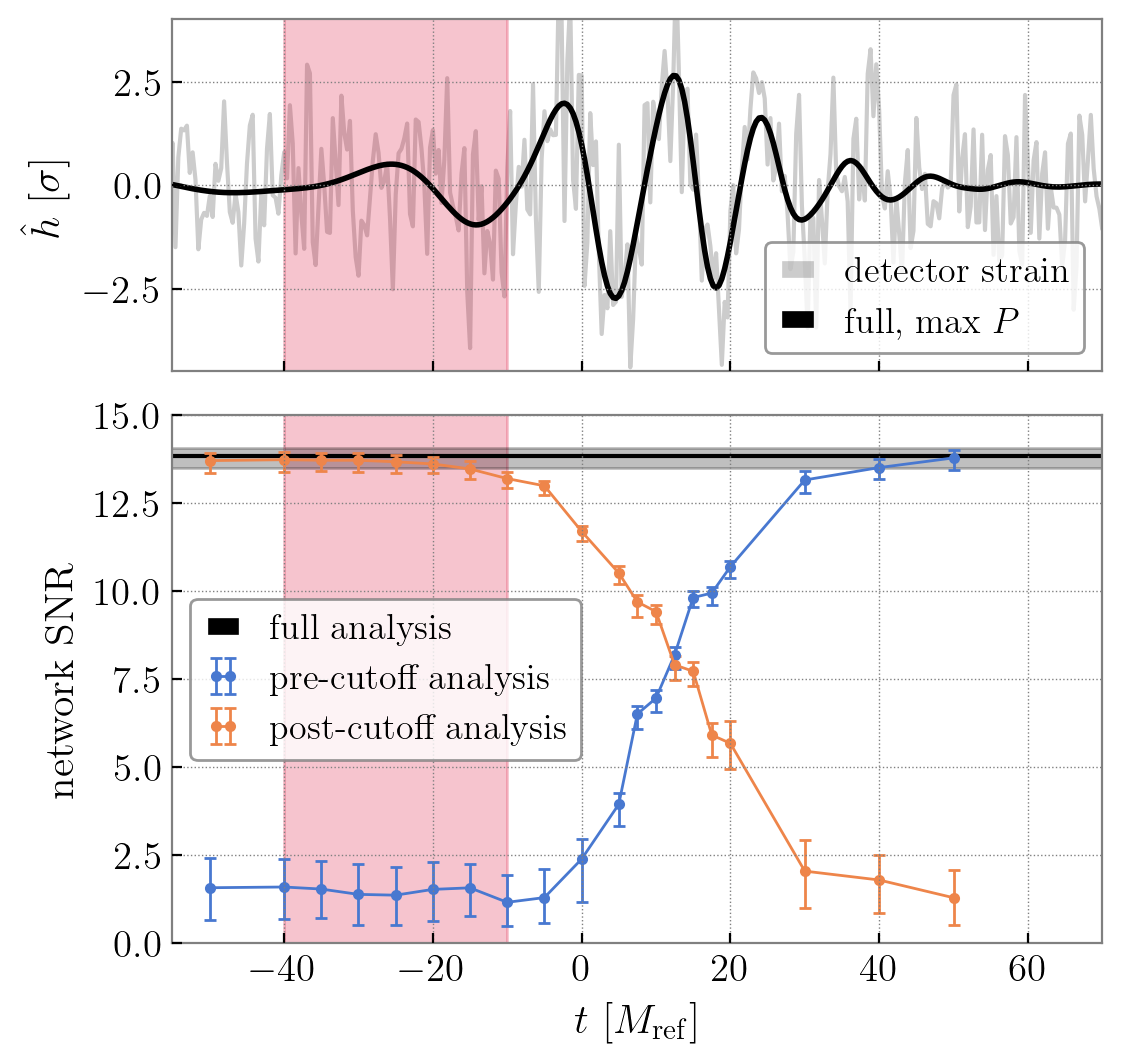

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [2, 3]})

for ax in axes:
    ax.set_rasterization_zorder(2)

'''
upper subplot: whitened time domain strain 
'''

# Plot detector data
axes[0].plot(reconstruction_times_M, L1_LVC_strain_wh, color='k', alpha=0.2, zorder=0, label='detector strain')

# Plot maxP full waveform 
axes[0].plot(reconstruction_times_M, L1_maxP_strain_wh, color='k', alpha=1, zorder=1, lw=2, 
             label=r'full, max $P$')

axes[0].legend(frameon=True, fancybox=True, fontsize=13, loc='lower right')

axes[0].set_ylabel(r'$\hat h~[\sigma]$', fontsize=15)

fill_kws = dict(color='crimson', alpha=0.25, zorder=0)
axes[0].fill_betweenx((-5, 5), -40*np.ones(2), x2=-10*np.ones(2), **fill_kws)

# Set full axes limits
axes[0].set_xlim(-55, 70)
axes[0].set_ylim(-4.5, 4)

'''
lower subplot: snrs vs time for before vs. after runs
'''

# error bar plots
axes[1].errorbar(runs_before, network_snrs_before.T[1], fmt='.-',
             yerr = (network_snrs_before.T[1] - network_snrs_before.T[0], 
                    network_snrs_before.T[2] - network_snrs_before.T[1]), 
             color=cp[0], lw=1, capsize=2, label='pre-cutoff analysis')

axes[1].errorbar(runs_after, network_snrs_after.T[1], fmt='.-',
             yerr = (network_snrs_after.T[1] - network_snrs_after.T[0], 
                    network_snrs_after.T[2] - network_snrs_after.T[1]), 
             color=cp[1], lw=1, capsize=2, label='post-cutoff analysis')


# full snr 
axes[1].axhline(quants_network_snr_full[1], color='k', label='full analysis', zorder=1)
axes[1].fill_between((-100, 100), 
                     quants_network_snr_full[0]*np.ones(2), 
                     y2=quants_network_snr_full[2]*np.ones(2),
                     color='k', alpha=0.25, zorder=1)

axes[1].set_xlabel(r'$t~[M_\mathrm{ref}]$', fontsize=15)
axes[1].set_ylabel('network SNR', fontsize=15)
axes[1].legend(frameon=True, fancybox=True, fontsize=13)

axes[1].fill_betweenx((-5,20), -40*np.ones(2), x2=-10*np.ones(2), **fill_kws)

axes[1].set_ylim(0, 15)

plt.subplots_adjust(hspace=0.1)

plt.savefig('figure_08.pdf', bbox_inches='tight')
plt.show()